In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 

from utilities import *
from VoxelGrid import VoxelGrid
import os

from pyvox.models import Vox, Color
from pyvox.writer import VoxWriter


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200

In [4]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.62it/s]


In [5]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
200


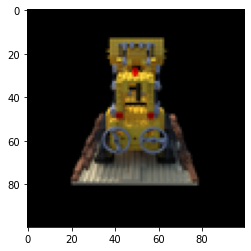

In [6]:
plt.imshow(target_ims[0])
plt.show()

In [7]:
test_focal, test_c2w, test_gt = get_data("../lego", "test")

LOAD DATA ../lego/test


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.25it/s]


In [8]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims[0].shape[0]

In [ ]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

 85%|███████████████████████████████████▋      | 85/100 [00:56<00:09,  1.53it/s]

In [ ]:
VG = VoxelGrid(32, 1.2)
VG.load('32_good.obj')
#VG.subdivide()

In [9]:
losses=[]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

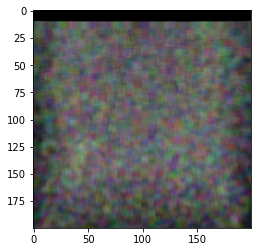

Train Epoch: 0 [0/25 (0%)]	Loss: 0.276550
Train Epoch: 0 [10/25 (40%)]	Loss: 0.143141
Train Epoch: 0 [20/25 (80%)]	Loss: 0.102593


 10%|████▍                                       | 1/10 [00:15<02:19, 15.49s/it]

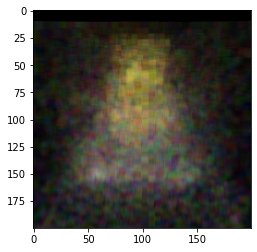

Train Epoch: 1 [0/25 (0%)]	Loss: 0.088968
Train Epoch: 1 [10/25 (40%)]	Loss: 0.071663
Train Epoch: 1 [20/25 (80%)]	Loss: 0.060120


 20%|████████▊                                   | 2/10 [00:31<02:04, 15.54s/it]

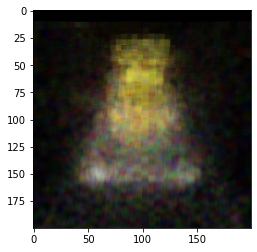

Train Epoch: 2 [0/25 (0%)]	Loss: 0.055839
Train Epoch: 2 [10/25 (40%)]	Loss: 0.049561
Train Epoch: 2 [20/25 (80%)]	Loss: 0.045533


 30%|█████████████▏                              | 3/10 [00:46<01:48, 15.54s/it]

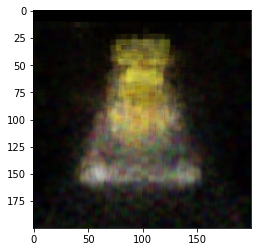

Train Epoch: 3 [0/25 (0%)]	Loss: 0.043935
Train Epoch: 3 [10/25 (40%)]	Loss: 0.040469
Train Epoch: 3 [20/25 (80%)]	Loss: 0.039342


 40%|█████████████████▌                          | 4/10 [01:02<01:33, 15.55s/it]

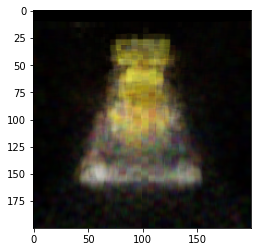

Train Epoch: 4 [0/25 (0%)]	Loss: 0.038055
Train Epoch: 4 [10/25 (40%)]	Loss: 0.036702
Train Epoch: 4 [20/25 (80%)]	Loss: 0.034306


 50%|██████████████████████                      | 5/10 [01:17<01:18, 15.60s/it]

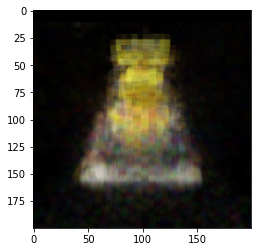

Train Epoch: 5 [0/25 (0%)]	Loss: 0.032656
Train Epoch: 5 [10/25 (40%)]	Loss: 0.033618
Train Epoch: 5 [20/25 (80%)]	Loss: 0.032573


 60%|██████████████████████████▍                 | 6/10 [01:33<01:02, 15.63s/it]

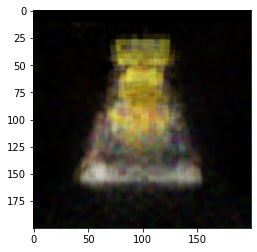

Train Epoch: 6 [0/25 (0%)]	Loss: 0.030150
Train Epoch: 6 [10/25 (40%)]	Loss: 0.029807
Train Epoch: 6 [20/25 (80%)]	Loss: 0.030280


 70%|██████████████████████████████▊             | 7/10 [01:49<00:46, 15.65s/it]

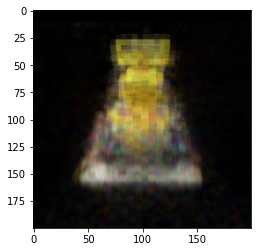

Train Epoch: 7 [0/25 (0%)]	Loss: 0.028592
Train Epoch: 7 [10/25 (40%)]	Loss: 0.029624
Train Epoch: 7 [20/25 (80%)]	Loss: 0.027296


 80%|███████████████████████████████████▏        | 8/10 [02:05<00:31, 15.71s/it]

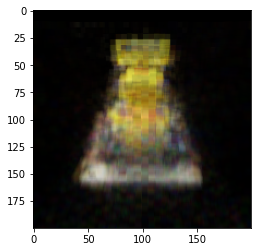

Train Epoch: 8 [0/25 (0%)]	Loss: 0.028040
Train Epoch: 8 [10/25 (40%)]	Loss: 0.028513
Train Epoch: 8 [20/25 (80%)]	Loss: 0.026036


 90%|███████████████████████████████████████▌    | 9/10 [02:20<00:15, 15.74s/it]

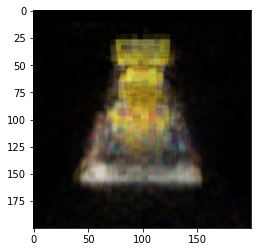

Train Epoch: 9 [0/25 (0%)]	Loss: 0.026964
Train Epoch: 9 [10/25 (40%)]	Loss: 0.026342
Train Epoch: 9 [20/25 (80%)]	Loss: 0.025602


100%|███████████████████████████████████████████| 10/10 [02:36<00:00, 15.67s/it]


In [24]:
N_points=200
def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        pix_estims = VG.render_rays(rays, (N_points))
        
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #loss = ((pix_estims-pixels)**2).sum()/rays.shape[0]
        loss.backward()
        losses.append(loss.item())
        VG.update_grads(1000)
        if batch_idx%1==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(10)):
    new_im = VG.render_image_from_rays(disp_rays[0],(1000,1.2))
    plt.imshow(new_im)
    plt.show()
    plt.imsave('screenshots/a'+str(epoch)+'.png', new_im)



    losses += train(epoch)
    #VG.save('80_'+str(epoch)+'.obj')
    
    

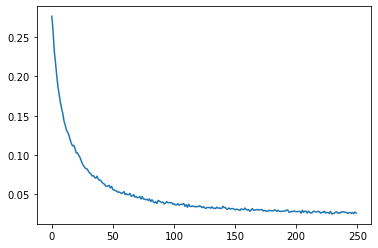

In [25]:
plt.plot((np.array(losses)))

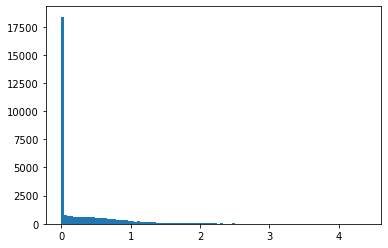

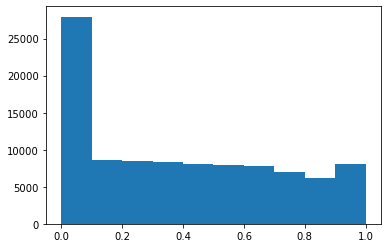

In [26]:
plt.hist(VG.opacities.tolist(), bins=100)
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




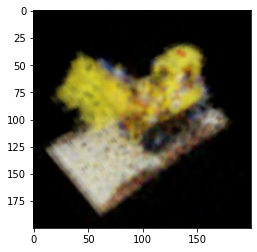

In [22]:
plt.imshow(VG2.render_image_from_rays(disp_rays[6],(1000, 1.2)))

In [20]:
VG2 = VG.copy()


In [21]:
VG2.treshold_opacity(0.4)

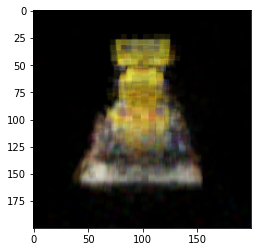

In [23]:
plt.imshow(VG2.render_image_from_rays(disp_rays[0],(1000, 1.2)))

In [26]:
VG.save_magica_vox(0.5)
#VG.save('.obj')

100%|███████████████████████████████████████████| 32/32 [00:03<00:00,  9.44it/s]


In [22]:
all_c2w[image_ind]

disp_rays[image_ind][0][0,:,0]**2

array([8.33201508, 6.31625955, 1.60172607])

# TEST

In [10]:
VG2 = VoxelGrid()
VG2.load('64_best.obj')
VG2.bound_w

1.2

In [22]:
len(disp_ims_test)

200

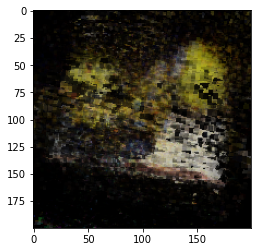

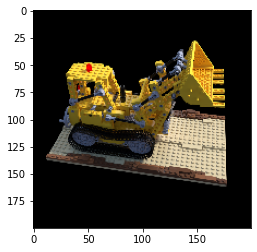

In [37]:
image_ind=28
tensor_rays_img = torch.tensor(disp_rays_test[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG2.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)
plt.show()
plt.imshow(disp_ims_test[image_ind])

# ROTATION

In [27]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [28]:
camera_centers = get_cameras_centers(rays_or_dir)

In [2]:
cust_c2ws = create_rotation_matrices(2,n=20)

[3.8 0.  1. ]


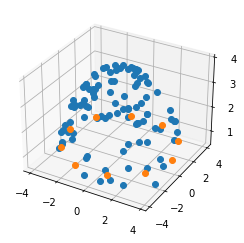

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 10
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [36]:
red_fac=4
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))



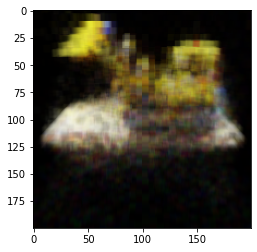

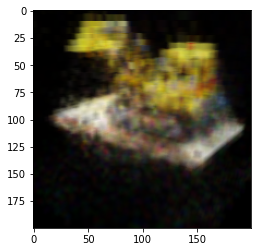

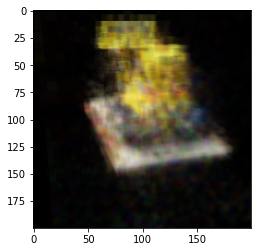

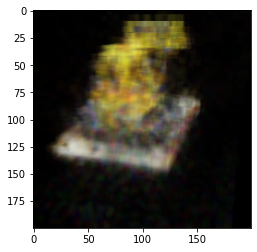

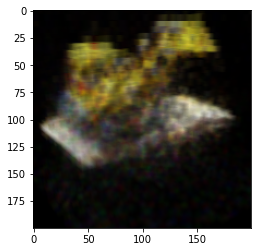

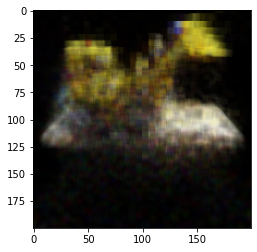

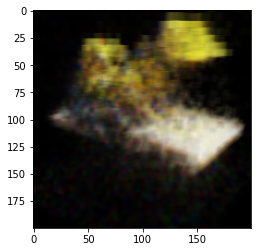

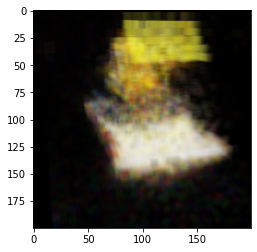

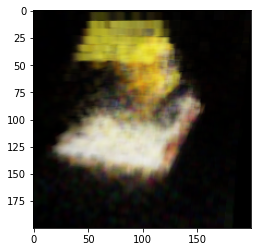

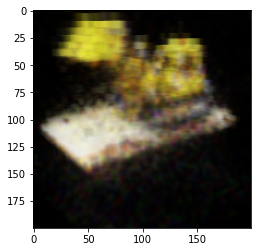

In [37]:
for image_ind in range(10):
    new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))

    plt.imshow(new_im)
    plt.show()